In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

In [2]:
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df['Close']

def calculate_returns(prices):
    returns = prices.pct_change().dropna()
    return returns

def calculate_alpha_beta(stock_returns, market_returns):
    slope, intercept, r_value, p_value, std_err = linregress(market_returns, stock_returns)
    return intercept, slope

def get_risk_free_rate(start_date, end_date, stock_ticker):
    if stock_ticker.endswith(".L"):
        rf_ticker = "^IRX"  # UK 3-Month Treasury Bill
    else:
        rf_ticker = "^TNX"  # US 10-Year Treasury Note

    rf = yf.Ticker(rf_ticker)
    rf_data = rf.history(start=start_date, end=end_date)
    
    if rf_ticker == "^IRX":
        # IRX is in percentage terms, so divide by 100, then annualize by dividing by 12 (monthly rate)
        rf_data['Daily Rate'] = rf_data['Close'] / 100 / 252
    else:
        # TNX is in percentage terms, so divide by 100, then annualize by dividing by 252 (daily rate)
        rf_data['Daily Rate'] = rf_data['Close'] / 100 / 252
    
    return rf_data['Daily Rate']

def get_market_index(stock_ticker):
    if stock_ticker.endswith(".L"):
        return "^FTSE"
    else:
        return "^GSPC"

In [4]:
# User input
ticker = input("Enter the stock ticker symbol: ")
market_index = '^GSPC'  # S&P 500 index
end_date = input("Enter the end date (YYYYMMDD): ")
years = int(input("Enter the number of years: "))

Enter the stock ticker symbol: AZN.L
Enter the end date (YYYYMMDD): 20240725
Enter the number of years: 5


In [10]:
try:
    end = datetime.strptime(end_date, "%Y%m%d")
    start = end - relativedelta(years=years)
except ValueError:
    print("Invalid date format. Please use YYYYMMDD.")
else:
    start_date_yf = start.strftime("%Y-%m-%d")
    end_date_yf = end.strftime("%Y-%m-%d")

    # Fetch stock data
    stock_prices = get_stock_data(ticker, start_date_yf, end_date_yf)
    
    # Determine and fetch market index data
    market_index = get_market_index(ticker)
    market_prices = get_stock_data(market_index, start_date_yf, end_date_yf)
    
    # Fetch risk-free rate data
    rf_data = get_risk_free_rate(start_date_yf, end_date_yf, ticker)

    # Calculate returns
    stock_returns = calculate_returns(stock_prices)
    market_returns = calculate_returns(market_prices)

    # Remove time component from index
    stock_returns.index = stock_returns.index.date
    market_returns.index = market_returns.index.date
    rf_data.index = rf_data.index.date

    # Create a DataFrame to hold all the data with a common date index
    combined_data = pd.DataFrame(index=stock_returns.index)
    combined_data['Stock Returns'] = stock_returns
    combined_data['Market Returns'] = market_returns
    combined_data['Risk-Free Rate'] = rf_data.reindex(combined_data.index)

    # Print combined data to debug alignment
    print("\nCombined Data (with aligned dates):")
    print(combined_data.head())

    # Drop rows with any NaN values
    combined_data = combined_data.dropna()

    if combined_data.empty:
        print("No overlapping data between stock returns, market returns, and risk-free rate.")
    else:
        # Adjust returns by the risk-free rate
        excess_stock_returns = combined_data['Stock Returns'] - combined_data['Risk-Free Rate']
        excess_market_returns = combined_data['Market Returns'] - combined_data['Risk-Free Rate']

        # Calculate alpha and beta
        alpha, beta = calculate_alpha_beta(excess_stock_returns, excess_market_returns)
        
        print(f"\nThe SCL regression equation for {ticker} is:")
        print(f"Excess Stock Return (ri - rf) = {alpha:.4f} + {beta:.4f} * Excess Market Return (rm - rf)")


Combined Data (with aligned dates):
            Stock Returns  Market Returns  Risk-Free Rate
2019-07-26       0.008029        0.008012        0.000082
2019-07-29       0.039826        0.018214        0.000081
2019-07-30      -0.007242       -0.005178        0.000081
2019-07-31      -0.009400       -0.007846        0.000081
2019-08-01       0.019686       -0.000250        0.000081

The SCL regression equation for AZN.L is:
Excess Stock Return (ri - rf) = 0.0005 + 0.6278 * Excess Market Return (rm - rf)


In [11]:
def calculate_annual_metrics(daily_returns):
    average_annual_return = np.mean(daily_returns) * 252
    annual_variance = np.var(daily_returns) * 252
    return average_annual_return, annual_variance

# Calculate annual metrics for the stock
stock_annual_return, stock_annual_variance = calculate_annual_metrics(stock_returns)

# Calculate annual metrics for the market index
market_annual_return, market_annual_variance = calculate_annual_metrics(market_returns)

# Print the results
print(f"\nAverage Annual Return for {ticker}: {stock_annual_return:.2%}")
print(f"Annual Variance for {ticker}: {stock_annual_variance:.2%}")

print(f"\nAverage Annual Return for {market_index}: {market_annual_return:.2%}")
print(f"Annual Variance for {market_index}: {market_annual_variance:.2%}")



Average Annual Return for AZN.L: 17.14%
Annual Variance for AZN.L: 6.15%

Average Annual Return for ^FTSE: 3.26%
Annual Variance for ^FTSE: 3.09%


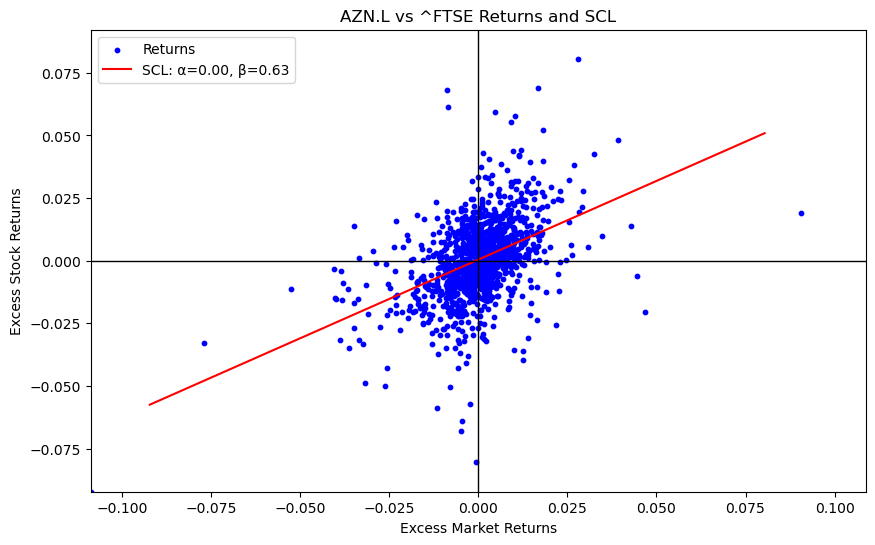

In [35]:
average_rf_daily = rf_data.mean()  # Average daily risk-free rate

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(excess_market_returns, excess_stock_returns, label='Returns', color='blue', s=10)

# Calculate the SCL
x = np.linspace(excess_stock_returns.min(), excess_stock_returns.max(), 100)
y = alpha + beta * (x - average_rf_daily)  # Use the average weekly risk-free rate

# Plot the SCL
plt.plot(x, y, color='red', label=f'SCL: α={alpha:.2f}, β={beta:.2f}')

# Chart details
plt.xlabel('Excess Market Returns')
plt.ylabel('Excess Stock Returns')

# Set the limits to center (0,0)
plt.xlim(left=-excess_market_returns.abs().max(), right=excess_market_returns.abs().max())
plt.ylim(bottom=-excess_stock_returns.abs().max(), top=excess_stock_returns.abs().max())

# Draw the x and y axes at (0, 0)
plt.axhline(0, color='black', lw=1)  # X-axis
plt.axvline(0, color='black', lw=1)  # Y-axis

# Remove grid lines
plt.grid(False)

# Move the legend to the upper left corner
plt.legend(loc='upper left')

plt.title(f'{ticker} vs {market_index} Returns and SCL')
plt.show()